# Anchor explanations for fashion
This notebook demonstrates how to use Anchor explanations to understand the predictions of a Convolutional Neural Network (CNN) trained on the Fashion MNIST dataset. Anchor explanations provide insights into which parts of an image are most influential in the model's decision-making process.

The notebook follows these steps:

1. Load and prepare the Fashion MNIST dataset: The dataset is loaded, scaled, reshaped, and categorized for training and testing.
2. Define the CNN model: A CNN model is defined using TensorFlow and Keras.
3. Train the model: The CNN model is trained on the training data.
4. Define superpixels: The image is divided into superpixels, which are groups of pixels that are similar in color and texture. These superpixels are used by the Anchor explainer to identify the important regions of the image.
5. Define prediction function: A prediction function is defined to predict the class of an image using the trained model.
6. Initialize anchor image explainer: The AnchorImage explainer from the alibi library is initialized with the prediction function, image shape, and superpixel segmentation function.
7. Explain a prediction: An image from the test set is selected, and the explainer is used to generate an explanation for the model's prediction on this image.
8. Show anchor: The resulting anchor, which highlights the important regions of the image, is displayed.


**Imports alibi for anchor explanations.**

In [ ]:
!pip install -q alibi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.8 MB/s eta 0:00:00


# Anchor explanations for fashion MNIST
Loads and prepares the Fashion MNIST dataset. This includes scaling the pixel values, reshaping the data, and converting the labels to categorical format.

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import AnchorImage

### Load and prepare fashion MNIST data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


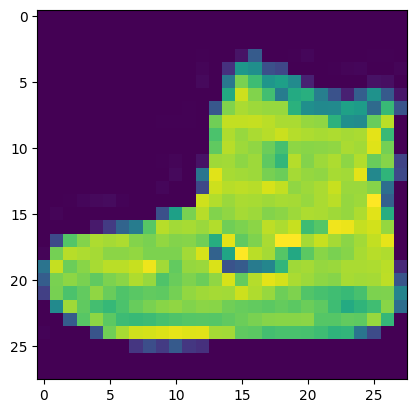

In [ ]:
idx = 0
plt.imshow(x_train[idx]);

Scale, reshape and categorize data

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


### Define CNN model
Defines the CNN model architecture using Keras. The model consists of convolutional layers, max pooling layers, dropout layers, and dense layers.

In [ ]:
def model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [ ]:
cnn = model()
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         401,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 412,778 (1.57 MB)

 Trainable params: 412,778 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

### Train model

In [ ]:
cnn.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - accuracy: 0.7067 - loss: 0.7956
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.8473 - loss: 0.4170
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - accuracy: 0.8683 - loss: 0.3611


In [ ]:
# Evaluate the model on test set
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.8866999745368958


### Define superpixels

Function to generate rectangular superpixels for a given image. Alternatively, use one of the built in methods. It is important to have meaningful superpixels in order to generate a useful explanation. Please check scikit-image's [segmentation methods](http://scikit-image.org/docs/dev/api/skimage.segmentation.html) (*felzenszwalb*, *slic* and *quickshift* built in the explainer) for more information on the built in methods.

In [ ]:
def superpixel(image, size=(4, 7)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

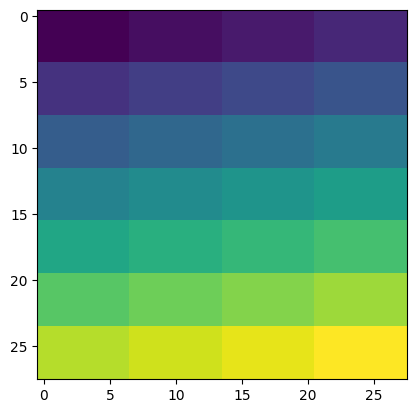

In [ ]:
segments = superpixel(x_train[idx])
plt.imshow(segments);

### Define prediction function

In [ ]:
predict_fn = lambda x: cnn.predict(x)

### Initialize anchor image explainer

Selects an image from the test set for explanation and displays it.

In [ ]:
image_shape = x_train[idx].shape
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=superpixel)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


### Explain a prediction

The explanation returns a mask with the superpixels that constitute the anchor.

Image to be explained:

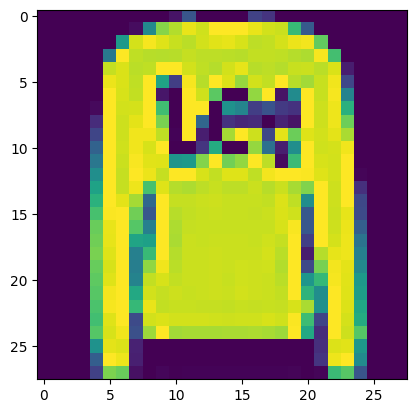

In [ ]:
i = 1
image = x_test[i]
plt.imshow(image[:,:,0]);

Model prediction:

In [ ]:
cnn.predict(image.reshape(1, 28, 28, 1)).argmax()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


2

The predicted category correctly corresponds to the class `Pullover`:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Generate explanation:

In [ ]:
explanation = explainer.explain(image, threshold=.95, p_sample=.8, seed=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Show anchor:

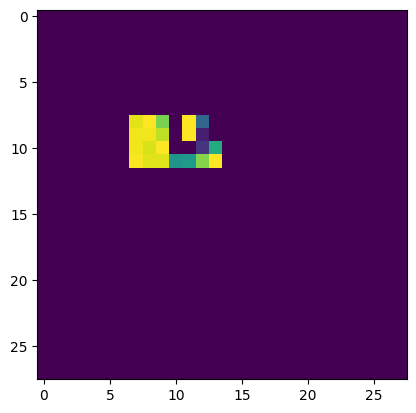

In [ ]:
plt.imshow(explanation.anchor[:,:,0]);